In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn import ensemble, impute, model_selection, preprocessing, tree
from yellowbrick.features import JointPlotVisualizer, Rank2D, RadViz, ParallelCoordinates

In [2]:
df = pd.read_csv('titanic3.csv')
orig_df = df.copy()

In [11]:
def tweak_titanic(df):
    return df.drop(['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'], axis=1) \
             .pipe(pd.get_dummies, drop_first=True)

def get_train_test_X_y(df, y_col, test_size=0.3, std_cols=None):
    y = df[y_col]
    x = df.drop(y_col, axis=1)

    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare"]

    X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=test_size, random_state=42)
    fi = impute.IterativeImputer()

    X_train.loc[:, num_cols]=fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

In [14]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: Setti

<AxesSubplot:ylabel='Frequency'>

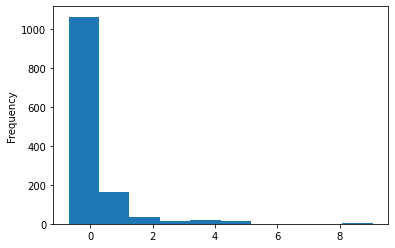

In [19]:
# Histogram
fig, ax = plt.subplots(figsize=(6,4))
X['fare'].plot(kind='hist', ax=ax)

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


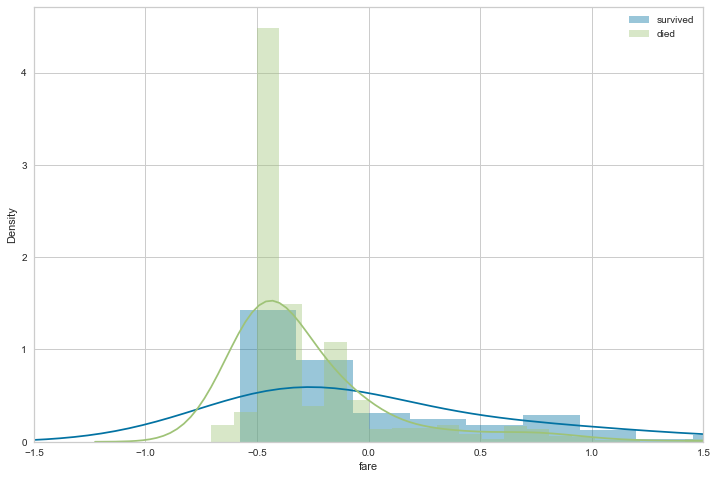

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
mask = y_train == 1
ax = sns.distplot(X_train[mask]['fare'], label='survived')
ax = sns.distplot(X_train[~mask]['fare'], label='died')
ax.set_xlim(-1.5, 1.5)
ax.legend()

<AxesSubplot:xlabel='age', ylabel='fare'>

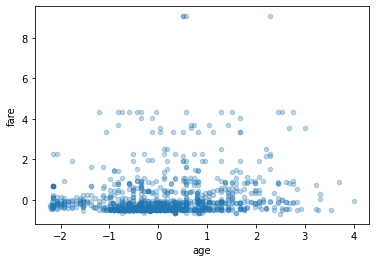

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
X.plot.scatter(x='age', y='fare', ax=ax, alpha=0.3)

In [21]:
X.age.corr(X.fare)

0.17720039845406144

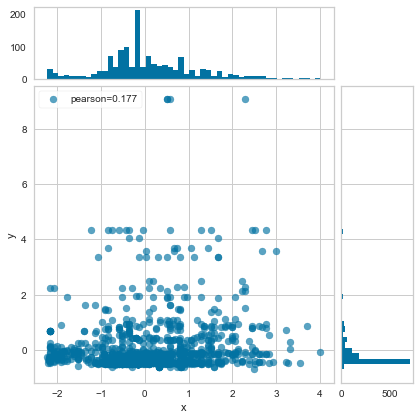

<AxesSubplot:xlabel='x', ylabel='y'>

In [25]:
fig, ax = plt.subplots(figsize=(6,6))
jpv = JointPlotVisualizer(feature='age', target='fare')
jpv.fit(X['age'], X['fare'])
jpv.poof()

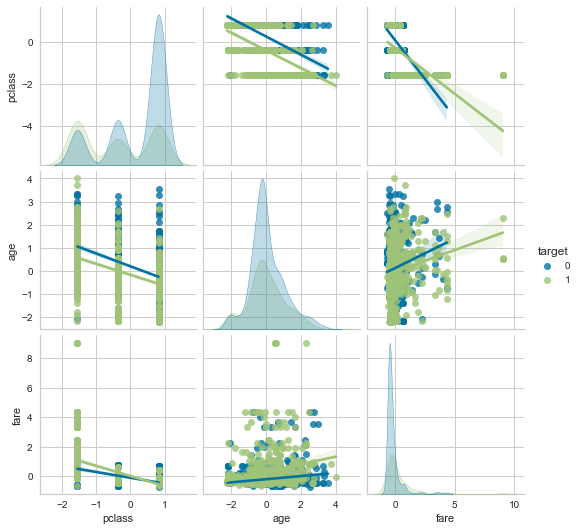

In [31]:
# Pairplot
new_df = X.copy()
new_df['target'] = y
vars = ['pclass', 'age', 'fare']
p = sns.pairplot(new_df, vars=vars, hue='target', kind='reg')

<AxesSubplot:xlabel='target', ylabel='age'>

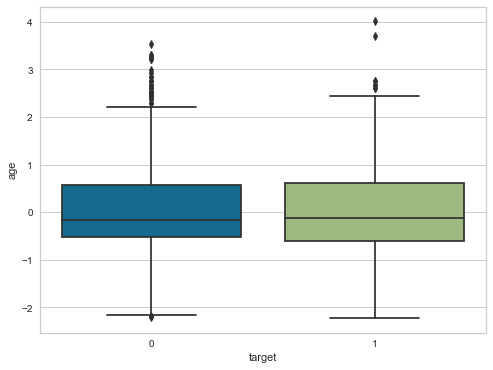

In [32]:
# Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
sns.boxplot(x="target", y="age", data=new_df)

<AxesSubplot:xlabel='target', ylabel='sex_male'>

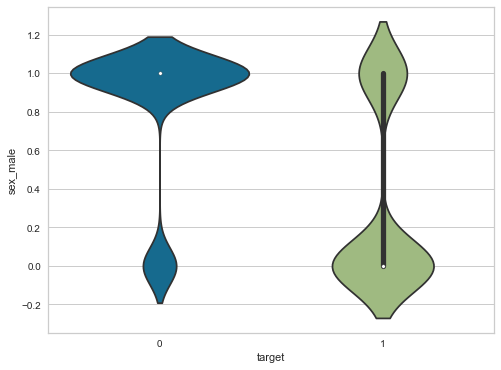

In [33]:
# Violin Plot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
sns.violinplot(x="target", y="sex_male", data=new_df)

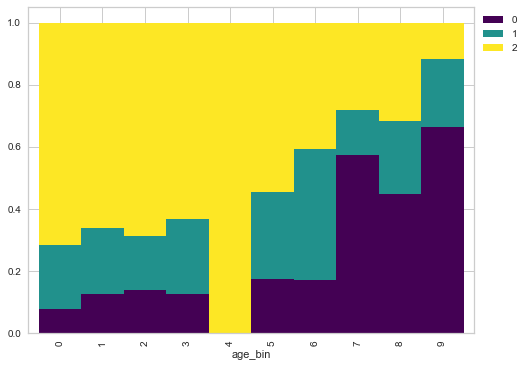

In [34]:
# Compare Ordinal Data
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)

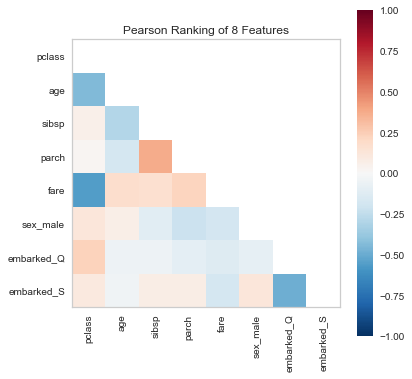

<AxesSubplot:title={'center':'Pearson Ranking of 8 Features'}>

In [36]:
# Correlation Matrix
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(features=X.columns, algorithm="pearson")
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()

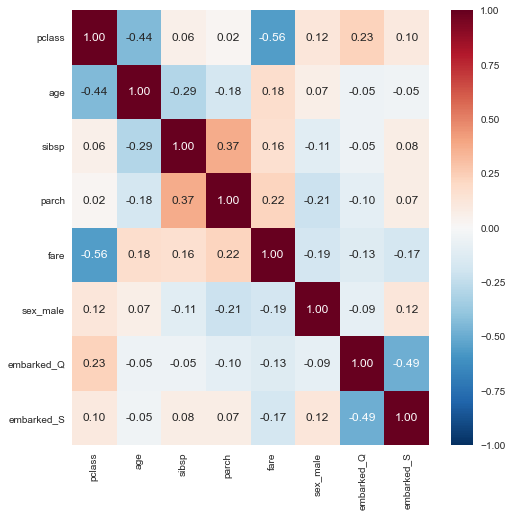

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(
    X.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

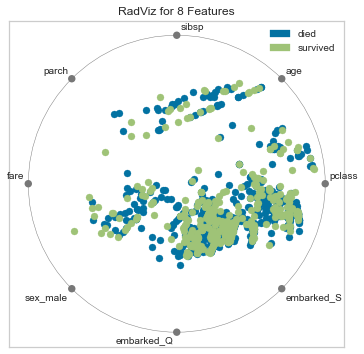

<AxesSubplot:title={'center':'RadViz for 8 Features'}>

In [39]:
# Radius Visualizer
fig, ax = plt.subplots(figsize=(6, 6))
rv = RadViz(
    classes=["died", "survived"],
    features=X.columns,
)
rv.fit(X, y)
_ = rv.transform(X)
rv.poof()

<ipython-input-41-f9c175b3fea0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


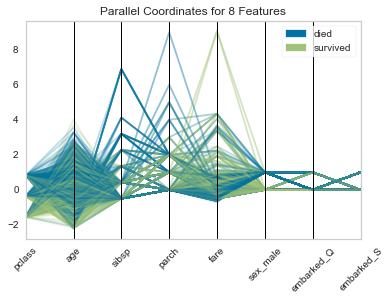

<AxesSubplot:title={'center':'Parallel Coordinates for 8 Features'}>

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
pc = ParallelCoordinates(
    classes=["died", "survived"],
    features=X.columns,
)
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
pc.poof()